In [88]:
import os
import yaml
import torch
from clean.data import DeepCleanInferenceDataset
from clean.infer import OnlineInference
from clean.model import InferenceModel

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.getcwd()

'/home/chiajui.chou/deepcleanv2/projects/clean'

In [3]:
# Loading configuration from YAML
clean_config_file = "/home/chiajui.chou/deepcleanv2/projects/clean/config_clean.yaml"
with open(clean_config_file, 'r') as file:
    clean_config = yaml.safe_load(file)
print(clean_config.keys())

train_config_file = os.path.join(clean_config['train_dir'], "config.yaml")
with open(train_config_file, 'r') as file:
    train_config = yaml.safe_load(file)
# print(train_config.keys())
print(train_config['data'].keys())
print(train_config['data']['inference_sampling_rate'])

# train_hparams_file = os.path.join(clean_config['train_dir'], "hparams.yaml")
# with open(train_hparams_file, 'r') as file:
#     train_hparams = yaml.safe_load(file)
# print(train_hparams.keys())

# Initialize InferenceModel
model = InferenceModel(
    clean_config['train_dir'],
    clean_config['sample_rate'],
    clean_config['device'],
)

# Initialize DeepCleanInferenceDataset
inference_dataset = DeepCleanInferenceDataset(
    hoft_dir=clean_config['hoft_dir'],
    witness_dir=clean_config['witness_dir'],
    model=model,
    device=clean_config['device'],
)

# Initialize OnlineInference
online_inference = OnlineInference(
    dataset=inference_dataset,
    model=model,
    outdir=clean_config['outdir'],
    device=clean_config['device']
)


dict_keys(['device', 'sample_rate', 'hoft_dir', 'witness_dir', 'outdir', 'train_dir'])
dict_keys(['fname', 'channels', 'kernel_length', 'freq_low', 'freq_high', 'batch_size', 'train_duration', 'test_duration', 'valid_frac', 'train_stride', 'inference_sampling_rate', 'start_offset', 'filt_order'])
2.0


In [4]:
# online_inference.model.model

In [5]:
# Run the online inference process for a number of iterations (e.g., 100)
# for k in range(300):
#     online_inference.predict_and_write()
#     online_inference.dataset.update()
#     print(f"iteration {k}")

### InferenceDataset

In [6]:
# Initialize DeepCleanInferenceDataset
inference_dataset = DeepCleanInferenceDataset(
    hoft_dir=clean_config['hoft_dir'],
    witness_dir=clean_config['witness_dir'],
    model=model,
    device=clean_config['device'],
)

print(inference_dataset.t0)
print(inference_dataset.kernel_size)
print("X_inference:")
print(inference_dataset.X_inference.kernel_size)
print(inference_dataset.X_inference.stride)
print("y_inference:")
print(inference_dataset.y_inference.kernel_size)
print(inference_dataset.y_inference.stride)

# print(inference_dataset.X_inference.X.shape)
# print(inference_dataset.y_inference.X.shape)
for i in inference_dataset.X_inference:
    print(i.shape)

1250916847
4096
X_inference:
4096
2048
y_inference:
4096
2048
torch.Size([5, 21, 4096])


In [7]:
print(inference_dataset.t0)
X_dset = inference_dataset.X_inference
y_dset = inference_dataset.y_inference
for X, y in zip(X_dset, y_dset):
    print(X.shape)
    print(X[0,0,:])
    print(y.shape)
    print(y[0,:])

# inference_dataset.update()
# print(inference_dataset.t0)

1250916847
torch.Size([5, 21, 4096])


tensor([0.6945, 0.7658, 0.7648,  ..., 0.3913, 0.3912, 0.3911], device='cuda:0')
torch.Size([5, 4096])
tensor([-1.8676e-19, -2.1235e-19, -1.8091e-19,  ...,  1.2468e-19,
         1.4771e-19,  1.4411e-19], device='cuda:0')


### Model

In [8]:
device = clean_config['device']
# print(clean_config)
train_dir = clean_config['train_dir']
# t_model = torch.jit.load(os.path.join(train_dir, "model.pt")).to(device)
t_model = model.model
print(type(t_model))

<class 'torch.jit._script.RecursiveScriptModule'>


### Predictions

tensor([[-1.8676e-19, -2.1235e-19, -1.8091e-19,  ...,  1.2468e-19,
          1.4771e-19,  1.4411e-19],
        [-2.8400e-20, -8.3440e-20, -1.1450e-19,  ...,  5.9551e-20,
          9.6161e-20,  1.5658e-19],
        [ 1.2101e-19,  9.0494e-20,  5.8145e-20,  ..., -1.2346e-19,
         -1.0429e-19, -7.1772e-20],
        [ 2.0658e-19,  2.1253e-19,  1.6874e-19,  ..., -1.1969e-20,
         -7.8928e-20, -9.5656e-20],
        [-4.4528e-20, -4.2582e-20, -6.6313e-20,  ...,  1.4624e-20,
         -1.7930e-20, -8.6482e-20]], device='cuda:0')


tensor([[-0.5482, -0.3632, -0.4498,  ..., -0.2987, -0.6487, -0.1573],
        [-0.5545, -0.3610, -0.4473,  ..., -0.2984, -0.6480, -0.1569],
        [-0.5181, -0.3778, -0.4712,  ..., -0.2983, -0.6476, -0.1565],
        [-0.5195, -0.3770, -0.4699,  ..., -0.2971, -0.6451, -0.1548],
        [-0.5189, -0.3772, -0.4703,  ..., -0.2945, -0.6417, -0.1528]],
       device='cuda:0', grad_fn=<SelectBackward0>)


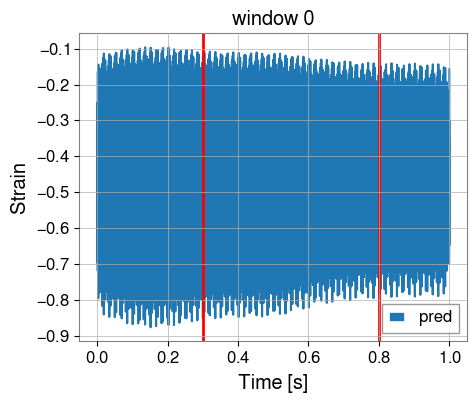

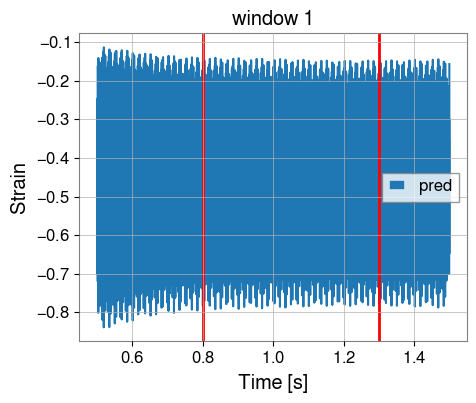

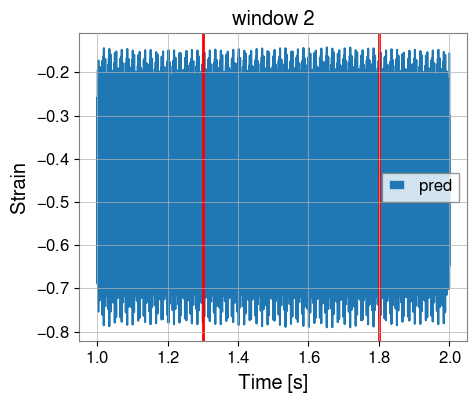

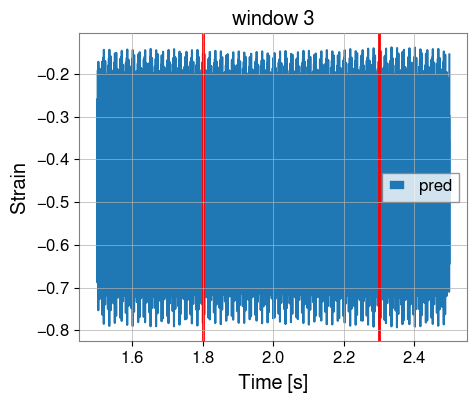

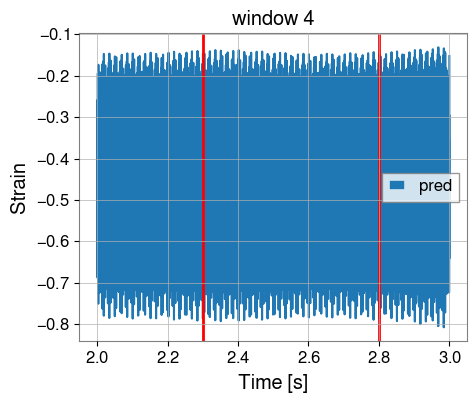

In [9]:
# inference_dataset.hparams
y = next(iter(y_dset))
print(y)
pred = t_model(next(iter(X_dset)))
print(pred)
for i in range(5):
    times = np.arange(i*0.5, i*0.5 + 1, 1/4096)
    plt.figure(figsize=[5,4])
    plt.title(f"window {i}")
    # plt.plot(times, y[i].to('cpu').numpy(), label="strain")
    plt.plot(times, pred[i].to('cpu').detach().numpy(), label="pred")
    plt.xlabel('Time [s]')
    plt.ylabel('Strain')
    st = i*0.5 + 1229/4096
    ed = st + 2048/4096
    plt.axvline(st, c='red', lw=2)
    plt.axvline([ed], c='red', lw=2)
    plt.legend()
    plt.show()

### Aggregation

edge_pad: 819, filter_pad: 3276
size: 12288, kernel_size: 4096, stride: 2048, batch_size = 5
offset: 1229


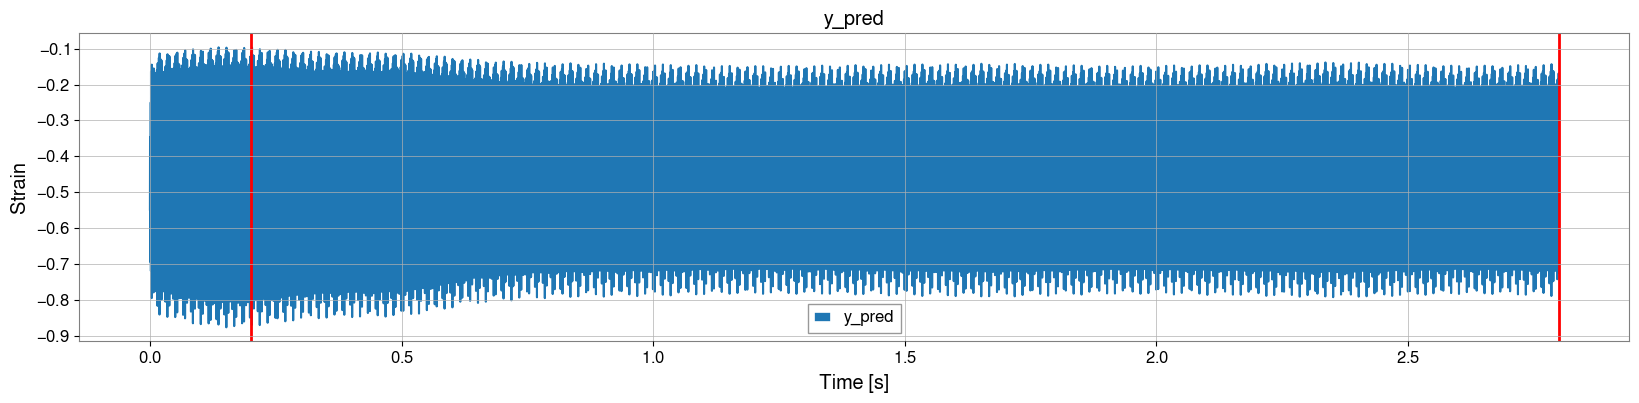

In [67]:
sample_rate = clean_config['sample_rate']
pad_params = train_config['model']['metric']['init_args']
edge_pad = int(pad_params.get('edge_pad') * sample_rate)
filter_pad = int(pad_params.get('filter_pad') * sample_rate)
print(f"edge_pad: {edge_pad}, filter_pad: {filter_pad}")

device = inference_dataset.hparams.device
dtype = inference_dataset.y_inference.X.dtype
size = len(inference_dataset.y_inference.X)
kernel_size = inference_dataset.kernel_size
stride = inference_dataset.stride
batch_size = len(next(iter(y_dset)))
print(f"size: {size}, kernel_size: {kernel_size}, stride: {stride}, batch_size = {batch_size}")

y_pred = torch.zeros(
    (size - edge_pad),
    device=device,
    dtype=dtype,
)
get_idx = torch.arange(
    stride,
    device=device,
)
offset = int(sample_rate - edge_pad - stride)
print(f"offset: {offset}")
get_idx += offset
# print(get_idx.shape)

set_idx = get_idx.view(1, -1).repeat(batch_size, 1)
# print(set_idx)
batch_offset = torch.arange(batch_size, device=device)
set_idx += batch_offset[:, None] * stride
# print(set_idx)

for i in range(1):
    y = pred
    sidx = set_idx[:len(y)]
    y_pred[sidx + i*batch_size*stride] = y[:, get_idx]
    if not i:
        y_pred[:offset] = y[0, :offset]

start = sample_rate - filter_pad
end = 2*sample_rate + filter_pad
# print(start, end)

plt.figure(figsize=[20, 4])
y_pred_times = np.arange(0, y_pred.shape[0]/sample_rate, 1/sample_rate)
plt.title('y_pred')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.plot(y_pred_times, y_pred.cpu().detach().numpy(), label='y_pred')
plt.axvline(y_pred_times[start], c='red', lw=2)
plt.axvline(y_pred_times[end], c='red', lw=2)
plt.legend()
plt.show()

times = y_pred_times[start:end]
noise = y_pred[start:end]

### Postprocess

In [68]:
noise = noise.double()
noise = model.y_scaler(noise.cpu(), reverse=True)
noise = model.bandpass(noise.detach().numpy())
noise = torch.tensor(noise, device=device)

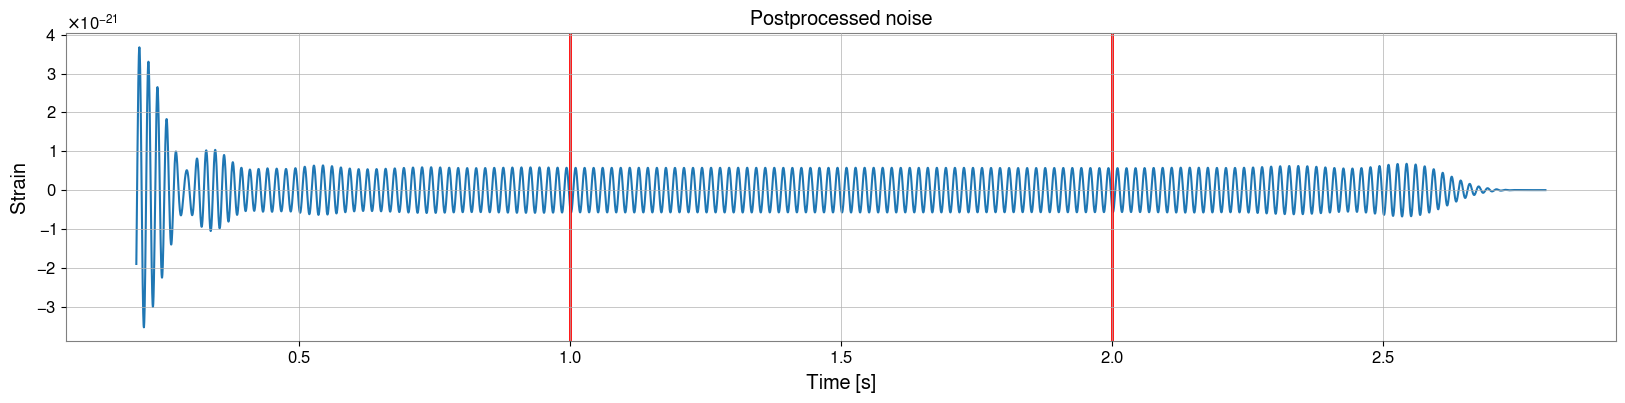

In [69]:
plt.figure(figsize=[20, 4])
plt.title('Postprocessed noise')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.plot(times, noise.cpu().detach().numpy())
plt.axvline(times[filter_pad], c='red', lw=2)
plt.axvline(times[filter_pad+sample_rate], c='red', lw=2)
plt.show()

In [70]:
times = times[filter_pad:-filter_pad]
noise = noise[filter_pad:-filter_pad]

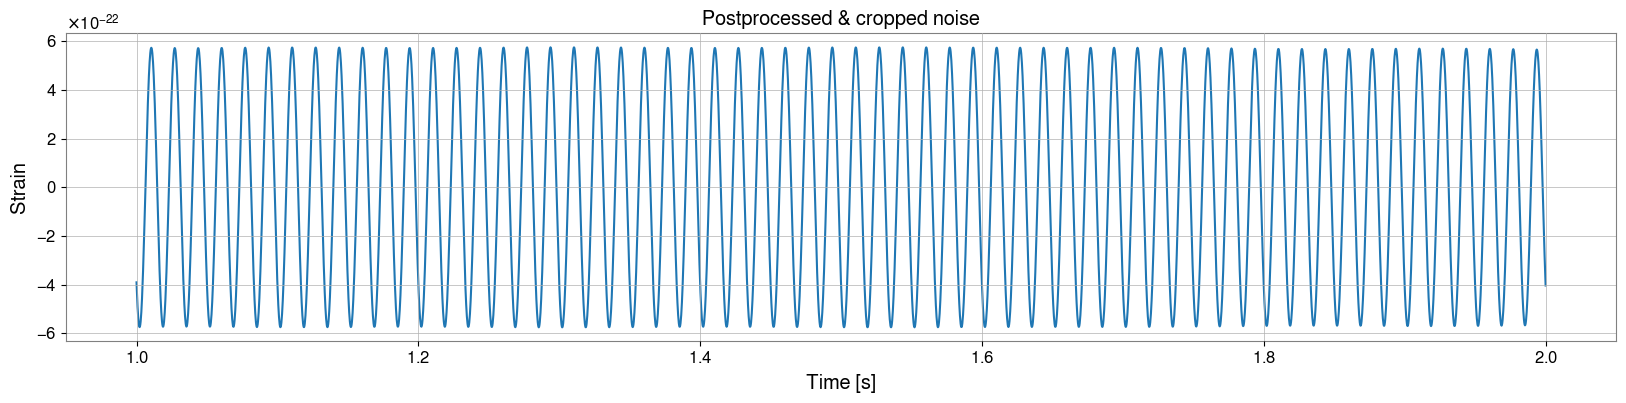

In [72]:
plt.figure(figsize=[20, 4])
plt.title('Postprocessed & cropped noise')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.plot(times, noise.cpu().detach().numpy())
plt.show()

### Load Raw Strain

Time labels from init buffer: [0.00000000e+00 2.44140625e-04 4.88281250e-04 ... 2.99926758e+00
 2.99951172e+00 2.99975586e+00], 12288
Time labels from the cropped y_pred: [1.         1.00024414 1.00048828 ... 1.99926758 1.99951172
 1.99975586], 4096
Time labels from predicted noise: [1.         1.00024414 1.00048828 ... 1.99926758 1.99951172
 1.99975586], 4096


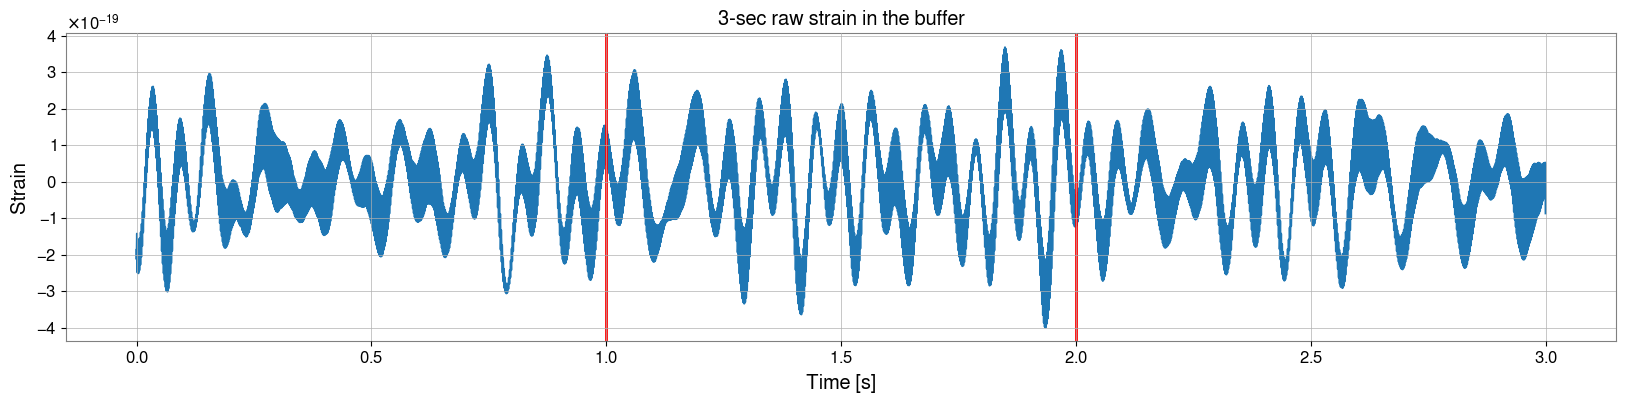

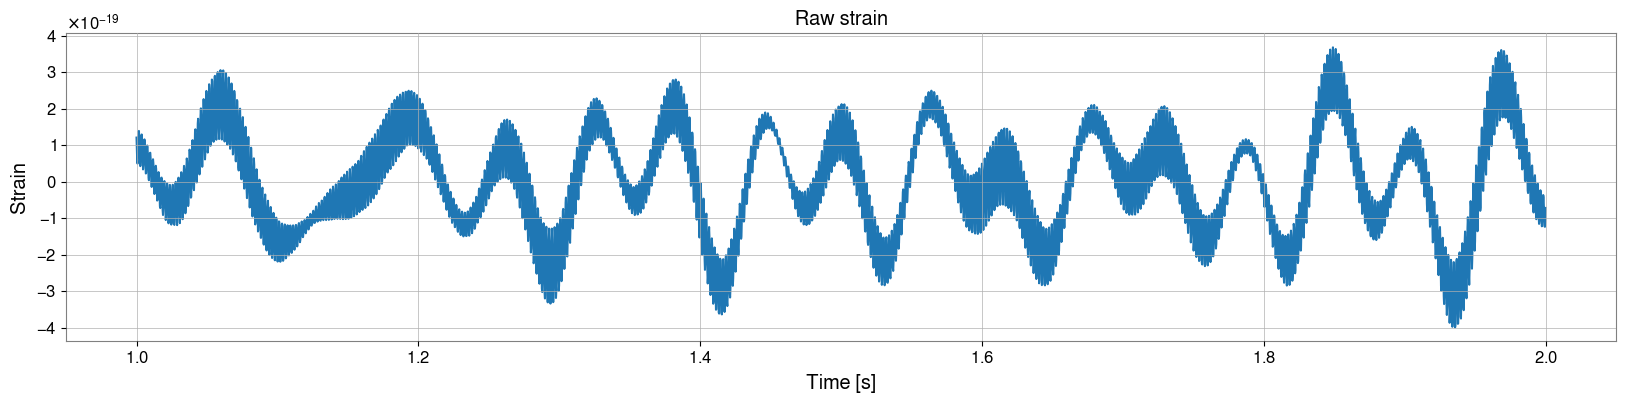

In [90]:
# print(inference_dataset.y_inference.X.shape)
init_times = np.arange(0, len(inference_dataset.y_inference.X)/sample_rate, 1/sample_rate)
print(f"Time labels from init buffer: {init_times}, {len(init_times)}")
print(f"Time labels from the cropped y_pred: {y_pred_times[start+filter_pad:end-filter_pad]}, {len(y_pred_times[start+filter_pad:end-filter_pad])}")
print(f"Time labels from predicted noise: {times}, {len(times)}")
raw_start = start + filter_pad
raw_end = end - filter_pad
raw = inference_dataset.y_inference.X[raw_start:raw_end]
# print(raw.shape)

buffer = inference_dataset.y_inference.X
buffer_times = np.arange(0, len(buffer)/sample_rate, 1/sample_rate)
plt.figure(figsize=[20, 4])
plt.title('3-sec raw strain in the buffer')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.plot(buffer_times, buffer.cpu().numpy())
plt.axvline(buffer_times[raw_start], c='red', lw=2)
plt.axvline(buffer_times[raw_end], c='red', lw=2)
plt.show()

plt.figure(figsize=[20, 4])
plt.title('Raw strain')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.plot(times, raw.cpu().numpy())
plt.show()

### Clean

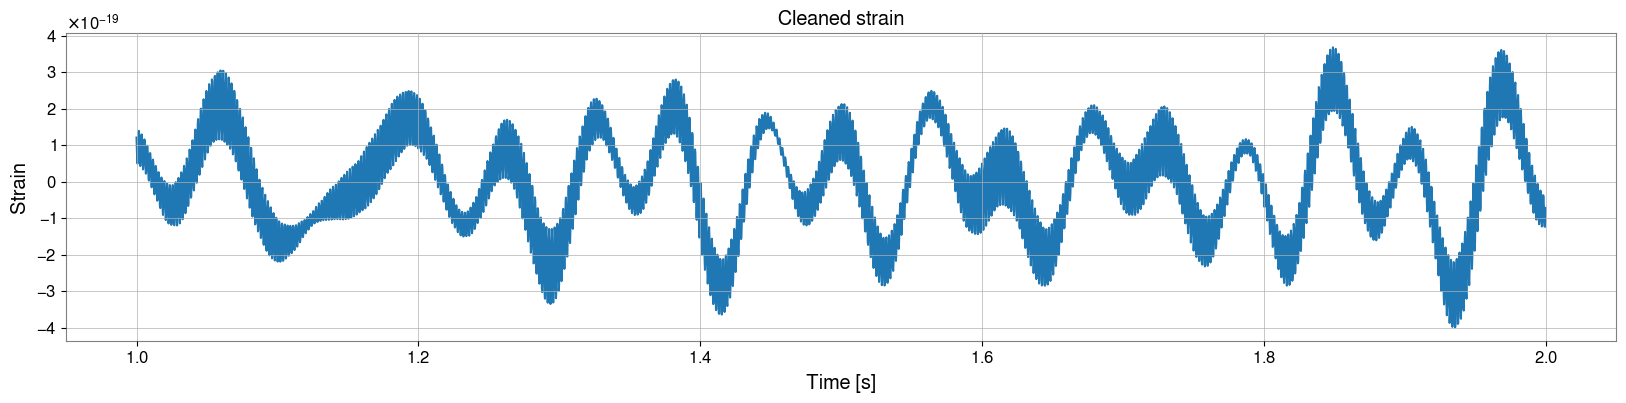

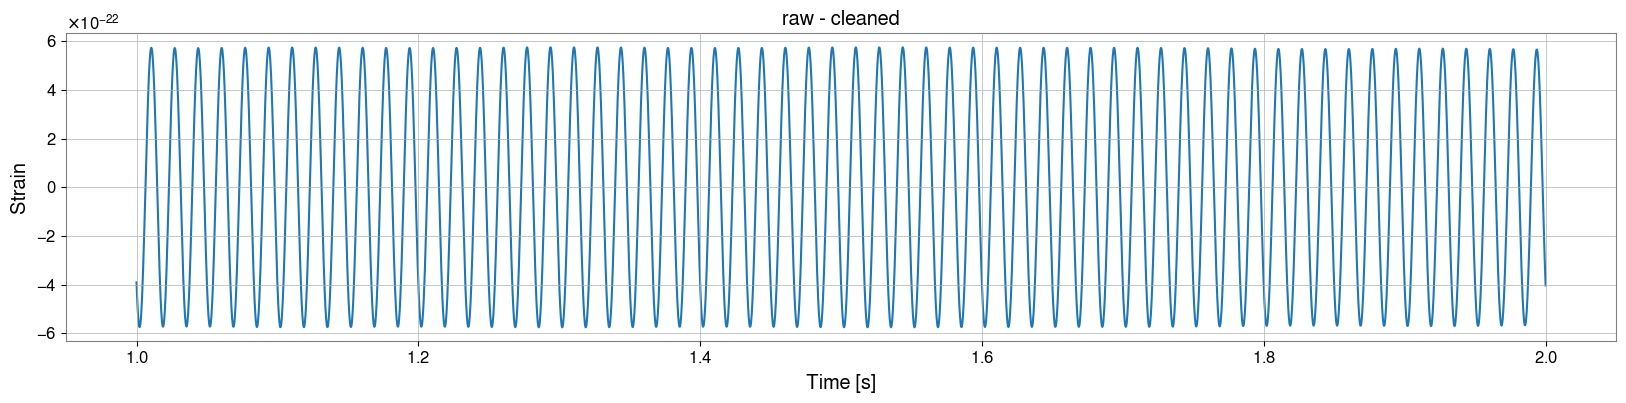

In [92]:
cleaned = raw - noise
plt.figure(figsize=[20, 4])
plt.title('Cleaned strain')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.plot(times, cleaned.cpu().numpy())
plt.show()

plt.figure(figsize=[20, 4])
plt.title('raw - cleaned')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.plot(times, (raw - cleaned).cpu().numpy())
plt.show()